In [1]:
import re
from datetime import datetime as dt

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from cartoframes.auth import set_default_credentials
from cartoframes.viz import Map, Layer, animation_widget, animation_style, basemaps

set_default_credentials('cartoframes')

In [2]:
def get_file_regex(prefix, file_datetime = None, suffix = None, ext = "csv"):
    if file_datetime is None:
        year_re = r"\d{4}"
        month_re = r"[a-zA-Z]{3}"
        day_re = r"\d{2}"
        hr_re = r"\d{2}"
        min_re = r"\d{2}"
        sec_re = r"\d{2}"
    else:
        date_string = file_datetime.strftime("%Y.%b.%d.%H.%M.%S")
        year_re, month_re, day_re, hr_re, min_re, sec_re = date_string.split(".")

    if suffix is None:
        suffix_re = r""
    else:
        suffix_re = r"\." + suffix

    file_re = re.compile(prefix+   r"\.("+ year_re + 
                                        r")\.(" + month_re + 
                                        r")\.(" + day_re    + 
                                        r")\.(" + hr_re +
                                        r")_(" + min_re + 
                                        r")_(" + sec_re + 
                                        r")" +suffix_re + 
                                        r"\." + ext + 
                                        r"")
    return file_re

def most_recent_directory_file(directory, file_regex):
    files = os.listdir(directory)
    filtered_files = [f for f in files if file_regex.search(f) is not None]
    filtered_files.sort(key = lambda x: dt_from_file_name(x, file_regex), reverse=True)
    return filtered_files[0]

def dt_from_file_name(file_name, regex):
    s = regex.search(file_name)
    file_dt = dt.strptime(''.join(s.groups()), "%Y%b%d%H%M%S")
    return file_dt

In [3]:
data_dir = "..\\output\\batch\\model_run_data\\"

project_crs = {'init': 'epsg:27700'}
wsg_crs = {'init':'epsg:4326'}

file_re = get_file_regex("pedestrian_locations")
ped_locations_file = most_recent_directory_file(data_dir, file_re)

df_ped_loc = pd.read_csv(os.path.join(data_dir, ped_locations_file))

# Now split df into one for locations, one for route coords
lo_cols = [i for i in df_ped_loc.columns if 'Loc' in i]

df_loc = df_ped_loc.dropna(subset = lo_cols)
for c in lo_cols:
    df_loc[c] = df_loc[c].map(float)


gdf_loc = gpd.GeoDataFrame(df_loc, geometry=gpd.points_from_xy(df_loc.LocXString, df_loc.LocYString))
gdf_loc.crs = project_crs

gdf_loc = gdf_loc.to_crs(wsg_crs)

C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Load the hexagonal bins and join with pedestrian trajectories to get the count per bin. Once processed save this as a new version of the hexagonal bins

In [5]:
'''
# Use hexagonal tiles to bin pedestrian locations, create heat map of trajectories
hex_polys_file = "S:\\CASA_obits_ucfnoth\\1. PhD Work\\GIS Data\\CoventGardenWaterloo\\hexgrid.shp"
gdf_hex = gpd.read_file(hex_polys_file)
print(gdf_hex.crs)

gdf_hex = gdf_hex.to_crs(wsg_crs)
gdf_hex['hex_id'] = np.arange(gdf_hex.shape[0])
print(gdf_hex.head())

# spatial join hex polys to the pedestrian locations
gdf_hex_traj = gpd.sjoin(gdf_hex, gdf_loc, op = 'contains')

# Get point count per hex per run
ser_hex_counts = gdf_hex_traj.groupby(["hex_id", "run"])['index_right'].apply(lambda df: df.shape[0])
df_hex_counts = pd.DataFrame(ser_hex_counts).reset_index().rename(columns = {'index_right':'loc_count'})

# Join back with the polygons
for run in gdf_loc['run'].unique():
    gdf_hex = pd.merge(gdf_hex, df_hex_counts.loc[ df_hex_counts['run'] == run, ['hex_id', 'loc_count']], on = 'hex_id', how = 'left').rename(columns = {'loc_count':'loc_count_run{}'.format(run)})
    

# Save the data
gdf_hex.to_file("C:\\Users\\obisargoni\\eclipse-workspace\\repastInterSim\\output\\hex_bin_trajectories\\hex_bin_trajectories.shp")
out_json_path = "C:\\Users\\obisargoni\\eclipse-workspace\\repastInterSim\\output\\hex_bin_trajectories\\hex_bin_trajectories.geojson"
gdf_hex.to_file(out_json_path, driver='GeoJSON')
'''

'\n# Use hexagonal tiles to bin pedestrian locations, create heat map of trajectories\nhex_polys_file = "S:\\CASA_obits_ucfnoth\\1. PhD Work\\GIS Data\\CoventGardenWaterloo\\hexgrid.shp"\ngdf_hex = gpd.read_file(hex_polys_file)\nprint(gdf_hex.crs)\n\ngdf_hex = gdf_hex.to_crs(wsg_crs)\ngdf_hex[\'hex_id\'] = np.arange(gdf_hex.shape[0])\nprint(gdf_hex.head())\n\n# spatial join hex polys to the pedestrian locations\ngdf_hex_traj = gpd.sjoin(gdf_hex, gdf_loc, op = \'contains\')\n\n# Get point count per hex per run\nser_hex_counts = gdf_hex_traj.groupby(["hex_id", "run"])[\'index_right\'].apply(lambda df: df.shape[0])\ndf_hex_counts = pd.DataFrame(ser_hex_counts).reset_index().rename(columns = {\'index_right\':\'loc_count\'})\n\n# Join back with the polygons\nfor run in gdf_loc[\'run\'].unique():\n    gdf_hex = pd.merge(gdf_hex, df_hex_counts.loc[ df_hex_counts[\'run\'] == run, [\'hex_id\', \'loc_count\']], on = \'hex_id\', how = \'left\').rename(columns = {\'loc_count\':\'loc_count_run{}\'.

### Load the already prepared hex bin count data

In [50]:
gdf_hex = gpd.read_file("C:\\Users\\obisargoni\\eclipse-workspace\\repastInterSim\\output\\hex_bin_trajectories\\hex_bin_trajectories.shp")
print(gdf_hex.columns)

Index(['left', 'bottom', 'right', 'top', 'hex_id', 'loc_count_', 'loc_coun_1',
       'loc_coun_2', 'loc_coun_3', 'loc_coun_4', 'loc_coun_5', 'loc_coun_6',
       'loc_coun_7', 'geometry'],
      dtype='object')


In [5]:
#gdf_hex = gdf_hex.to_crs(project_crs)

C:\Users\obisargoni\.conda\envs\gforge\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Use geopandas and contextily to make chloropleth map

In [51]:
import matplotlib.pyplot as plt
import contextily as cx

In [66]:
gdf_hex_run1 = gdf_hex.loc[ ~gdf_hex['loc_count_'].isnull()]
bb = gdf_hex_run1.total_bounds

In [90]:
im, bounds = cx.bounds2img(*bb, ll = True, source=cx.providers.CartoDB.Positron, zoom = 19)

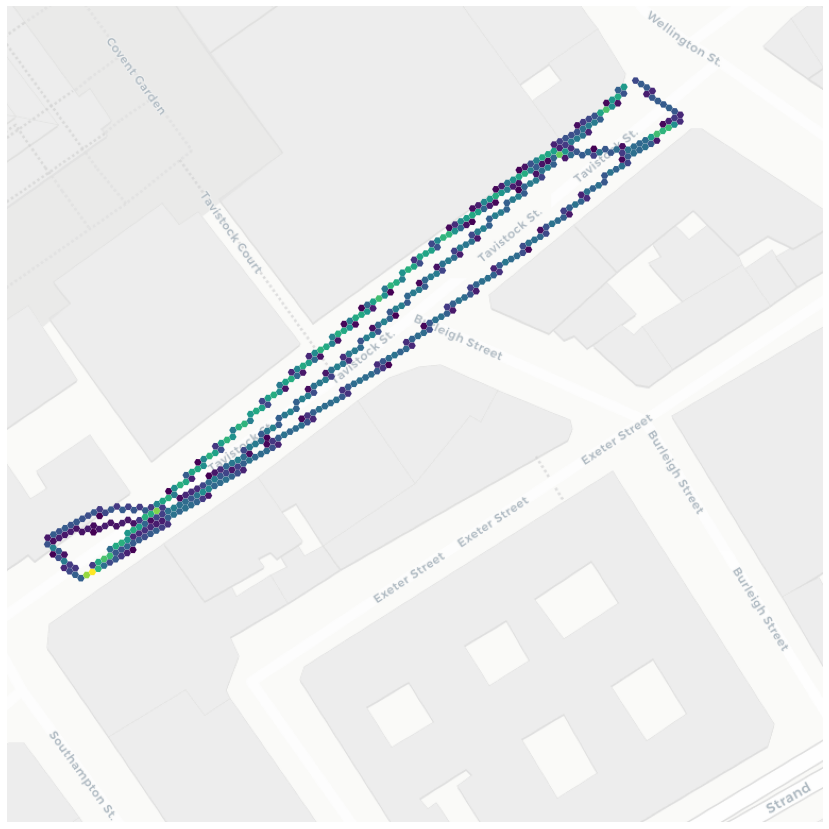

In [91]:
f, ax = plt.subplots(1, figsize = (15,15))
ax.set_axis_off()
ax.imshow(im, extent = bounds)
ax = gdf_hex_run1.to_crs(epsg=3857).plot(column='loc_count_',alpha=1, k=7, cmap=plt.cm.viridis, edgecolor='w', linewidth=0.1, ax = ax)

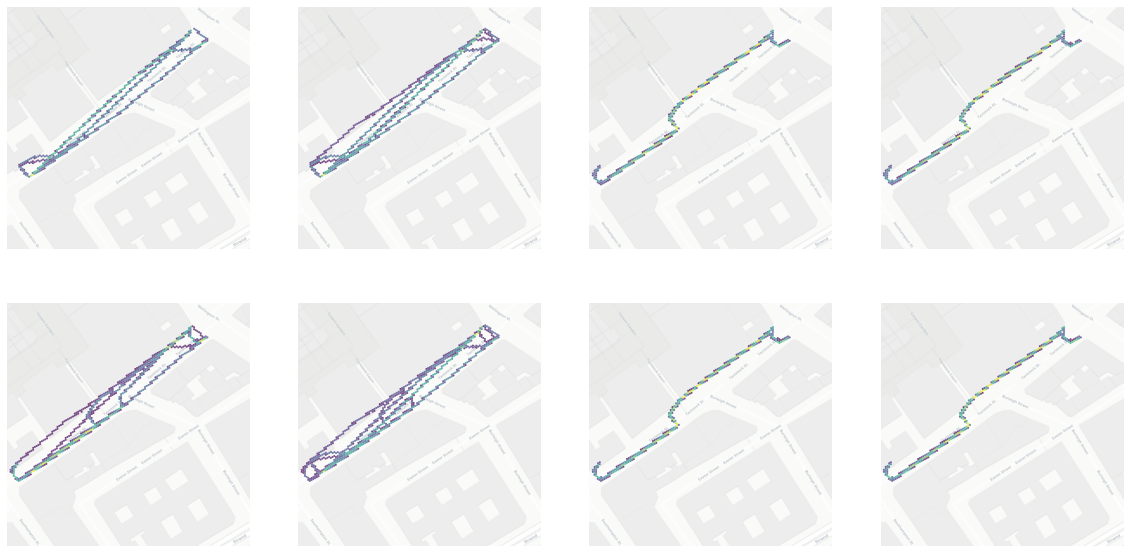

In [92]:
# Make a map for each run

f, axs = plt.subplots(2,4, figsize = (20,10), sharex= True, sharey = True)
cols = [c for c in gdf_hex.columns if 'loc_coun' in c]
for i in range(len(cols)):
    r = int(i/4)
    c = i % 4
    ax = axs[r,c]
    ax.set_axis_off()
    gdf_hex_run = gdf_hex.loc[ ~gdf_hex[cols[i]].isnull()]
    ax.imshow(im, extent = source)
    ax = gdf_hex_run.to_crs(epsg=3857).plot(column = cols[i], alpha = 0.7, cmap = plt.cm.viridis, edgecolor = 'none', ax = ax, legend = False)

In [93]:
f.savefig("..\\output\\img\\binned_trajectories_w_background.png")

### Use cartoframes to make chloropleth map

In [62]:
from cartoframes.viz import Layout, Map, Layer, color_bins_style, size_continuous_style, default_legend

# Generate maps
def hex_map(col, title = None):
    # Create heat map
    m = Map([
        Layer(
            gdf_hex.dropna(subset = [col]),
            style=color_bins_style(
                col,
                bins=5,
                palette='burgyl',
                stroke_width=0
            ),
            legends=None,
            default_legend=False,
            default_popup_hover=False,
            default_popup_click=False
        )
    ],
    title=title,
    basemap=basemaps.voyager)
    
    return m

m = hex_map("loc_count_")

cols = [c for c in gdf_hex.columns if 'loc_coun' in c]
maps = [hex_map(c) for c in cols]

In [56]:
gdf_hex.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
m

In [64]:

# Create heat map
from cartoframes.viz import Layout, Map, Layer, color_bins_style, size_continuous_style, default_legend

Layout(maps,2,4,viewport={'zoom': 17}, map_height=400)


### Use plotly to make a chloropleth map

In [21]:
# Load libraries
import json
import plotly.express as px

In [28]:
gdf_hex.head()

left         bottom          right            top  \
0  530275.0  180545.596259  530276.333334  180546.750960   
1  530275.0  180546.750960  530276.333334  180547.905661   
2  530275.0  180547.905661  530276.333334  180549.060362   
3  530275.0  180549.060362  530276.333334  180550.215063   
4  530275.0  180550.215063  530276.333334  180551.369764   

                                            geometry  hex_id  loc_count_run1  \
0  POLYGON ((-0.12419 51.50884, -0.12419 51.50884...       0             NaN   
1  POLYGON ((-0.12419 51.50885, -0.12419 51.50885...       1             NaN   
2  POLYGON ((-0.12419 51.50886, -0.12419 51.50886...       2             NaN   
3  POLYGON ((-0.12419 51.50887, -0.12419 51.50887...       3             NaN   
4  POLYGON ((-0.12419 51.50888, -0.12419 51.50888...       4             NaN   

   loc_count_run3  loc_count_run5  loc_count_run7  loc_count_run2  \
0             NaN             NaN             NaN             NaN   
1             NaN             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN             NaN             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   loc_count_run4  loc_count_run6  loc_count_run8  
0             NaN             NaN             NaN  
1             NaN             NaN             NaN  
2             NaN             NaN             NaN  
3             NaN             NaN             NaN  
4             NaN             NaN             NaN

In [ ]:
# Read geojson
with open(out_json_path) as geo_data:
    hex_bins = json.load(geo_data)

df = gdf_hex.loc[ ~(gdf_hex['loc_count_run1'].isnull())]

fig = px.choropleth(df, geojson=hex_bins, locations='hex_id', color='loc_count_run1',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12)
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()